In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn

In [2]:
N = 10000
d = 4
n_train = int(N * 0.8)
n_val = int(N * 0.2)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Simulate a dataset

In [4]:
np.random.seed(9345)

In [5]:
phi = np.random.normal(size=(N,1))

In [6]:
def noisy_polynomial(x):
    x = x.squeeze()
    n = len(x)
    a = np.random.choice(range(1, 5))
    b = np.random.choice(range(1, 4))
    c = np.random.normal(size=(n,))
    return np.power(x, a) + np.power(x, b) + x + c

In [7]:
x = np.column_stack([noisy_polynomial(phi) for _ in range(d)])

In [8]:
np.column_stack((phi[1:1000],x[1:1000])).shape

(999, 5)

In [9]:
data_df = pd.DataFrame(np.column_stack((phi[1:1001], x[1:1001])), columns=["phi"] + [f"x{c + 1}" for c in range(x.shape[1])])

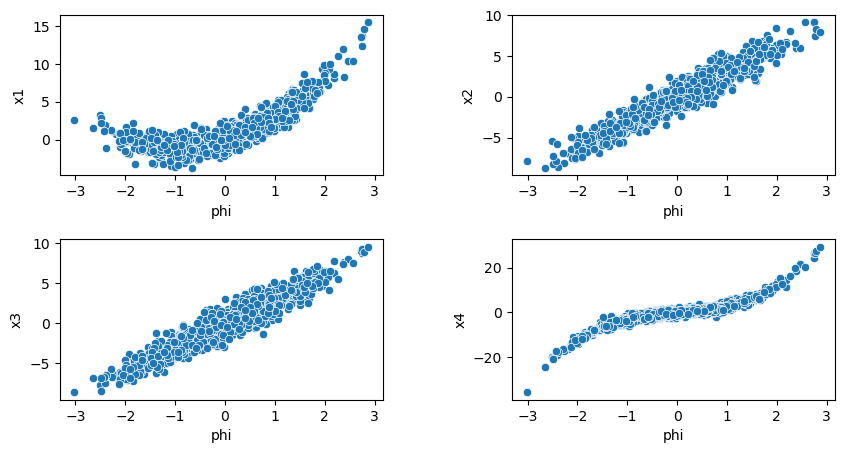

In [10]:
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(data_df, x="phi", y="x1")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(data_df, x="phi", y="x2")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(data_df, x="phi", y="x3")
ax = fig.add_subplot(2, 2, 4)
sns.scatterplot(data_df, x="phi", y="x4")
plt.show()


In [11]:
data_df.shape

(1000, 5)

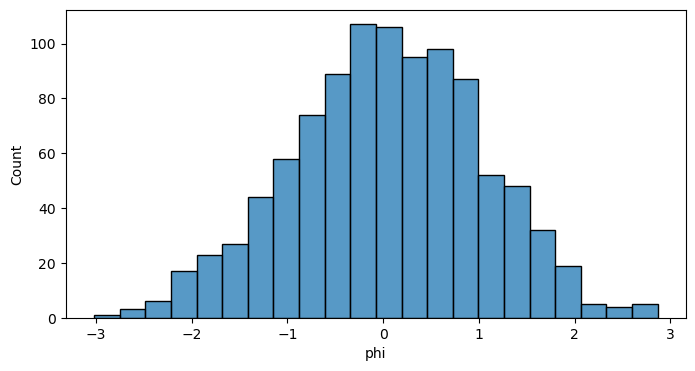

In [12]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
sns.histplot(data_df, x="phi")
plt.show()

# Autoencoder

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, hidden_depth):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.input_bnorm = nn.BatchNorm1d(hidden_dim)
        self.hidden_layers = nn.ModuleList()
        self.hidden_bnorm_layers = nn.ModuleList()
        for _ in range(hidden_depth):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        for _ in range(hidden_depth):
            self.hidden_bnorm_layers.append(nn.BatchNorm1d(hidden_dim))
        self.output_layer = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        x = F.leaky_relu(self.input_layer(x))
        x = self.input_bnorm(x)
        for i, layer in enumerate(self.hidden_layers):
            x = F.leaky_relu(layer(x))
            x = self.hidden_bnorm_layers[i](x)
        x = self.output_layer(x)
        return x


class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, hidden_depth):
        super().__init__()
        self.input_layer = nn.Linear(latent_dim, hidden_dim)
        self.input_bnorm = nn.BatchNorm1d(hidden_dim)
        self.hidden_layers = nn.ModuleList()
        self.hidden_bnorm_layers = nn.ModuleList()
        for _ in range(hidden_depth):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        for _ in range(hidden_depth):
            self.hidden_bnorm_layers.append(nn.BatchNorm1d(hidden_dim))
        self.output_layer = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        x = F.leaky_relu(self.input_layer(x))
        x = self.input_bnorm(x)
        for i, layer in enumerate(self.hidden_layers):
            x = F.leaky_relu(layer(x))
            x = self.hidden_bnorm_layers[i](x)
        x = self.output_layer(x)
        return x


class AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, hidden_depth=1):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, hidden_depth)
        self.decoder = Decoder(input_dim, hidden_dim, latent_dim, hidden_depth)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [14]:
def train(model, crit, opt, x_train, x_val):
    for epoch in range(n_epochs):

        # Train
        net.train()
        total_train_loss = 0.0
        avg_train_loss = 0.0

        total_val_loss = 0.0
        avg_val_loss = 0.0

        for i, start in enumerate(range(0, x_train.shape[0], batch_size)):
            inputs = x_train[start:start + batch_size, :]
            inputs = torch.from_numpy(inputs).to(torch.float32).to(device)

            opt.zero_grad()

            outputs = model(inputs)
            loss = crit(outputs, inputs)
            loss.backward()
            opt.step()
            total_train_loss += loss.item()
            # Divide total loss by number of mini batches
            avg_train_loss = total_train_loss / (i + 1)
        if (epoch + 1) % 25 == 0 or epoch == 0:
            print(f"[{epoch + 1}] avg. train loss: {np.round(avg_train_loss, 3)}")

            # Validate
            with torch.no_grad():
                net.eval()
                for i, start in enumerate(range(0, x_val.shape[0], batch_size)):
                    inputs = x_val[start:start + batch_size, :]
                    inputs = torch.from_numpy(inputs).to(torch.float32).to(device)

                    outputs = model(inputs)
                    loss = crit(outputs, inputs)
                    total_val_loss += loss.item()
                    avg_val_loss = total_val_loss / (i + 1)
                print(f"[x] avg. val loss: {np.round(avg_val_loss, 3)}")


In [15]:
hidden_dim = x.shape[1] * 4
latent_dim = 1
n_epochs = 1000
batch_size = 256

In [16]:
x.shape

(10000, 4)

In [17]:
x_train = x[:n_train]
x_val = x[n_train:]

In [18]:
net = AE(
    input_dim=x.shape[1],
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    hidden_depth=2
).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [19]:
print(net)

AE(
  (encoder): Encoder(
    (input_layer): Linear(in_features=4, out_features=16, bias=True)
    (input_bnorm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden_layers): ModuleList(
      (0-1): 2 x Linear(in_features=16, out_features=16, bias=True)
    )
    (hidden_bnorm_layers): ModuleList(
      (0-1): 2 x BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (output_layer): Linear(in_features=16, out_features=1, bias=True)
  )
  (decoder): Decoder(
    (input_layer): Linear(in_features=1, out_features=16, bias=True)
    (input_bnorm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden_layers): ModuleList(
      (0-1): 2 x Linear(in_features=16, out_features=16, bias=True)
    )
    (hidden_bnorm_layers): ModuleList(
      (0-1): 2 x BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (output_layer): Linear(in_features=16, o

In [20]:
train(net, criterion, optimizer, x_train, x_val)

[1] avg. train loss: 12.337
[x] avg. val loss: 12.286
[25] avg. train loss: 1.242
[x] avg. val loss: 0.809
[50] avg. train loss: 1.201
[x] avg. val loss: 0.808
[75] avg. train loss: 1.073
[x] avg. val loss: 0.833
[100] avg. train loss: 1.003
[x] avg. val loss: 0.897
[125] avg. train loss: 0.985
[x] avg. val loss: 0.964
[150] avg. train loss: 0.939
[x] avg. val loss: 0.924
[175] avg. train loss: 0.91
[x] avg. val loss: 0.947
[200] avg. train loss: 0.906
[x] avg. val loss: 0.9
[225] avg. train loss: 0.884
[x] avg. val loss: 0.882
[250] avg. train loss: 0.88
[x] avg. val loss: 0.895
[275] avg. train loss: 0.905
[x] avg. val loss: 0.875
[300] avg. train loss: 0.872
[x] avg. val loss: 0.862
[325] avg. train loss: 0.866
[x] avg. val loss: 0.836
[350] avg. train loss: 0.866
[x] avg. val loss: 0.847
[375] avg. train loss: 0.845
[x] avg. val loss: 0.822
[400] avg. train loss: 0.848
[x] avg. val loss: 0.846
[425] avg. train loss: 0.841
[x] avg. val loss: 0.823
[450] avg. train loss: 0.842
[x] av

In [21]:
with torch.no_grad():
    # Will set all network layers to train mode
    net.eval()
    x_val_torch = torch.from_numpy(x_val).to(torch.float32).to(device)
    x_train_torch = torch.from_numpy(x_train).to(torch.float32).to(device)
    phi_hat_val = net.encoder(x_val_torch).detach().to("cpu").numpy()
    phi_hat_train = net.encoder(x_train_torch).detach().to("cpu").numpy()

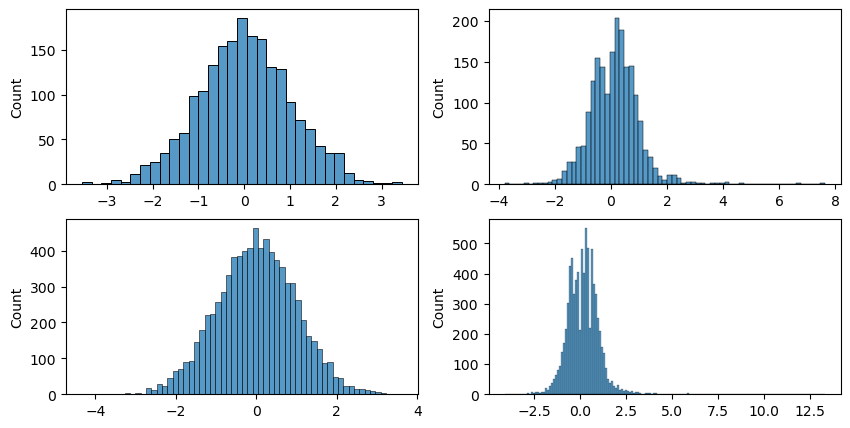

In [22]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(2, 2, 1)
sns.histplot(x=phi[n_train:].squeeze())
ax = fig.add_subplot(2, 2, 2)
sns.histplot(x=phi_hat_val.squeeze())
ax = fig.add_subplot(2, 2, 3)
sns.histplot(x=phi[:n_train].squeeze())
ax = fig.add_subplot(2, 2, 4)
sns.histplot(x=phi_hat_train.squeeze())
plt.show()